In [4]:
import os
import cv2
import numpy as np
import torch
import pandas as pd
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms

# Environment variable
main_img_dir = "/media/mountHDD3/data_storage/biomedical_data/Dataset/VinDr-Mammo-PNG-MAMMO-CLIP-CROPPED-TEXT_REMOVE-FLIP-MEDIAN-CLAHE-UNSHARP"

train_label = '/media/mountHDD3/data_storage/biomedical_data/Dataset/VinDr-Mammo/Processed/train_df.csv'
val_label = '/media/mountHDD3/data_storage/biomedical_data/Dataset/VinDr-Mammo/Processed/val_df.csv'
test_label = '/media/mountHDD3/data_storage/biomedical_data/Dataset/VinDr-Mammo/Processed/test_df.csv'

target_size = (256,256)

# Custom dataset class for mammography data
class MammographyDataset(Dataset):
    def __init__(self, df_path, img_dir, target_size, transform=None):
        self.df = pd.read_csv(df_path)
        self.img_dir = img_dir
        self.target_size = target_size
        self.transform = transform
        self.images, self.metadata, self.labels = self.load_data()

    def load_data(self):
        images, labels = [], []
        age, density = [], []
        
        le_birads = LabelEncoder()  # LabelEncoder for 'breast_birads'
        le_density = LabelEncoder()  # LabelEncoder for 'breast_density'
        
        for _, row in self.df.iterrows():
            img = cv2.imread(os.path.join(self.img_dir, row['image_id']+'.png'))
            if self.transform:
                img = self.transform(img)
            images.append(img)
            labels.append(row['breast_birads'])  # Add breast_birads label
            age.append(float(row['age']))  # Add age
            density.append(row['breast_density'])  # Add breast density

        labels = le_birads.fit_transform(labels)  # Encode breast_birads
        labels = torch.tensor(labels).long()  # Convert labels to tensor
        
        density_encoded = le_density.fit_transform(density)  # Encode breast_density
        density_tensor = torch.tensor(density_encoded).float()  # Convert encoded density to tensor
        
        metadata = {
            'age': torch.tensor(age).float(),  # Convert age to tensor
            'breast_density': density_tensor,  # Use encoded breast_density tensor
        }
        return images, metadata, labels

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return self.images[idx], self.metadata['age'][idx], self.metadata['breast_density'][idx], self.labels[idx]


In [5]:
# Define data transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_dataset = MammographyDataset(train_label, main_img_dir, target_size, transform=transform)
test_dataset = MammographyDataset(test_label, main_img_dir, target_size, transform=transform)
val_dataset = MammographyDataset(val_label, main_img_dir, target_size, transform=transform)


In [6]:
from torch.utils.data import DataLoader

# Tạo DataLoader cho train, val, test
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


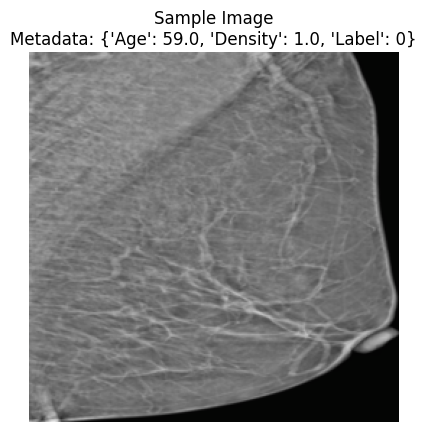

In [7]:
import matplotlib.pyplot as plt

# Lấy một batch mẫu từ train_loader
images, age, density, labels = next(iter(train_loader))

# Chọn một mẫu để hiển thị (ở đây chọn mẫu đầu tiên trong batch)
img = images[0].permute(1, 2, 0).numpy()  # Đổi thứ tự từ (C, H, W) thành (H, W, C) để vẽ ảnh
img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Denormalize the image

metadata = {
    'Age': age[0].item(),
    'Density': density[0].item(),
    'Label': labels[5].item()  # Class label (được mã hóa dưới dạng số nguyên)
}

# Vẽ ảnh
plt.imshow(img)
plt.title(f"Sample Image\nMetadata: {metadata}")
plt.axis('off')
plt.show()


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class MultimodalModel(nn.Module):
    def __init__(self):
        super(MultimodalModel, self).__init__()

        # Image model using MobileNetV2
        self.image_model = models.mobilenet_v2(weights='DEFAULT')  # Cập nhật để sử dụng weights
        self.image_model.classifier = nn.Identity()  # Remove the final classification layer

        # Metadata processing layers
        self.age_norm = nn.BatchNorm1d(1)  # Normalize age

        # Embedding layers for breast density
        self.breast_density_emb = nn.Embedding(4, 4)  # Assuming 4 unique breast density categories

        # Fully connected layers
        self.fc_image = nn.Linear(1280, 512)
        self.fc_metadata = nn.Linear(1 + 4, 512)  # 1 age + 4 breast_density

        # Fully connected layer for final classification
        self.fc_combined = nn.Linear(512 * 2, 5)  # Combine image and metadata features, số lớp là 5

    def forward(self, x_image, age, breast_density):
        # Process image
        x_image = self.image_model(x_image)
        x_image = F.relu(self.fc_image(x_image))

        # Process metadata
        age_norm = self.age_norm(age.view(-1, 1))  # Reshape age to be (batch_size, 1)

        # Ensure breast_density is of type Long
        breast_density = breast_density.long()  # Convert to Long

        # Get embeddings for breast density
        breast_density_emb = self.breast_density_emb(breast_density)

        # Concatenate metadata features
        metadata = torch.cat([age_norm, breast_density_emb], dim=1)  # Result will be (batch_size, 5)
        x_metadata = F.relu(self.fc_metadata(metadata))

        # Concatenate features from image and metadata
        combined = torch.cat([x_image, x_metadata], dim=1)

        # Final classification layer
        output = self.fc_combined(combined)
        return output


In [9]:
from tqdm import tqdm 
num_epochs = 2
for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
    images, age, density, labels = batch
    
    # In ra kích thước và giá trị của các tensor
    print("Images shape:", images.shape)
    print("Age shape:", age.shape)
    print("Density shape:", density.shape)
    print("Labels shape:", labels.shape)
    
    # In ra một vài giá trị cụ thể để kiểm tra
    # print("Sample images:", images[0])  # In ra hình ảnh đầu tiên trong batch
    print("Sample age:", age[0])        # In ra giá trị tuổi đầu tiên trong batch
    print("Sample density:", density[0])  # In ra giá trị độ dày đầu tiên trong batch
    print("Sample labels:", labels[0])  # In ra nhãn đầu tiên trong batch

    # Thêm câu lệnh break để chỉ xem một batch đầu tiên
    break


NameError: name 'epoch' is not defined

In [ ]:
# import numpy as np

# # Giả sử bạn đã lấy nhãn từ train_loader
# for batch in train_loader:
#     images, age, density, labels = batch
#     print("Unique labels in the batch:", np.unique(labels.numpy()))



Epoch 1/30 [Validation]: 100%|███████████████████████████████████████████████████████| 256/256 [00:01<00:00, 192.09it/s]


Epoch [1/30], Train Loss: 0.9670, Train Accuracy: 0.6535, Val Loss: 0.9507, Val Accuracy: 0.6571


Epoch 2/30 [Validation]: 100%|███████████████████████████████████████████████████████| 256/256 [00:01<00:00, 190.99it/s]


Epoch [2/30], Train Loss: 0.9089, Train Accuracy: 0.6601, Val Loss: 0.9164, Val Accuracy: 0.6673


Epoch 3/30 [Validation]: 100%|███████████████████████████████████████████████████████| 256/256 [00:01<00:00, 166.68it/s]


Epoch [3/30], Train Loss: 0.8395, Train Accuracy: 0.6762, Val Loss: 0.9214, Val Accuracy: 0.6702


Epoch 4/30 [Validation]: 100%|███████████████████████████████████████████████████████| 256/256 [00:01<00:00, 193.73it/s]


Epoch [4/30], Train Loss: 0.7547, Train Accuracy: 0.6973, Val Loss: 1.0154, Val Accuracy: 0.6434


Epoch 5/30 [Validation]: 100%|███████████████████████████████████████████████████████| 256/256 [00:01<00:00, 198.17it/s]


Epoch [5/30], Train Loss: 0.6542, Train Accuracy: 0.7324, Val Loss: 1.0755, Val Accuracy: 0.6351


Epoch 6/30 [Validation]: 100%|███████████████████████████████████████████████████████| 256/256 [00:01<00:00, 195.54it/s]


Epoch [6/30], Train Loss: 0.5252, Train Accuracy: 0.7828, Val Loss: 1.2793, Val Accuracy: 0.6150


Epoch 7/30 [Validation]: 100%|███████████████████████████████████████████████████████| 256/256 [00:01<00:00, 177.29it/s]


Epoch [7/30], Train Loss: 0.4067, Train Accuracy: 0.8391, Val Loss: 1.5012, Val Accuracy: 0.5584


Epoch 8/30 [Validation]: 100%|███████████████████████████████████████████████████████| 256/256 [00:01<00:00, 194.57it/s]


Epoch [8/30], Train Loss: 0.2989, Train Accuracy: 0.8852, Val Loss: 1.8732, Val Accuracy: 0.5892


Epoch 9/30 [Validation]: 100%|███████████████████████████████████████████████████████| 256/256 [00:01<00:00, 177.14it/s]


Epoch [9/30], Train Loss: 0.2462, Train Accuracy: 0.9060, Val Loss: 1.9188, Val Accuracy: 0.5945


Epoch 10/30 [Validation]: 100%|██████████████████████████████████████████████████████| 256/256 [00:01<00:00, 171.91it/s]


Epoch [10/30], Train Loss: 0.2168, Train Accuracy: 0.9195, Val Loss: 1.9909, Val Accuracy: 0.5970


Epoch 11/30 [Validation]: 100%|██████████████████████████████████████████████████████| 256/256 [00:01<00:00, 179.80it/s]


Epoch [11/30], Train Loss: 0.1932, Train Accuracy: 0.9305, Val Loss: 1.8977, Val Accuracy: 0.5877


Epoch 12/30 [Validation]: 100%|██████████████████████████████████████████████████████| 256/256 [00:01<00:00, 183.32it/s]


Epoch [12/30], Train Loss: 0.1678, Train Accuracy: 0.9370, Val Loss: 2.2498, Val Accuracy: 0.5960


Epoch 13/30 [Validation]: 100%|██████████████████████████████████████████████████████| 256/256 [00:01<00:00, 176.67it/s]


Epoch [13/30], Train Loss: 0.1607, Train Accuracy: 0.9395, Val Loss: 2.2533, Val Accuracy: 0.5442


Epoch 14/30 [Validation]: 100%|██████████████████████████████████████████████████████| 256/256 [00:01<00:00, 191.32it/s]


Epoch [14/30], Train Loss: 0.1477, Train Accuracy: 0.9458, Val Loss: 2.2750, Val Accuracy: 0.5740


Epoch 15/30 [Validation]: 100%|██████████████████████████████████████████████████████| 256/256 [00:01<00:00, 188.73it/s]


Epoch [15/30], Train Loss: 0.1343, Train Accuracy: 0.9500, Val Loss: 2.3633, Val Accuracy: 0.5662


Epoch 16/30 [Validation]: 100%|██████████████████████████████████████████████████████| 256/256 [00:01<00:00, 191.66it/s]


Epoch [16/30], Train Loss: 0.1321, Train Accuracy: 0.9505, Val Loss: 2.2140, Val Accuracy: 0.5633


Epoch 17/30 [Validation]: 100%|██████████████████████████████████████████████████████| 256/256 [00:01<00:00, 183.01it/s]


Epoch [17/30], Train Loss: 0.1243, Train Accuracy: 0.9555, Val Loss: 2.2514, Val Accuracy: 0.5862


Epoch 18/30 [Validation]: 100%|██████████████████████████████████████████████████████| 256/256 [00:01<00:00, 193.57it/s]


Epoch [18/30], Train Loss: 0.1130, Train Accuracy: 0.9591, Val Loss: 2.3450, Val Accuracy: 0.5652


Epoch 19/30 [Validation]: 100%|██████████████████████████████████████████████████████| 256/256 [00:01<00:00, 178.84it/s]


Epoch [19/30], Train Loss: 0.1159, Train Accuracy: 0.9585, Val Loss: 2.2752, Val Accuracy: 0.5638


Epoch 20/30 [Validation]: 100%|██████████████████████████████████████████████████████| 256/256 [00:01<00:00, 188.37it/s]


Epoch [20/30], Train Loss: 0.1064, Train Accuracy: 0.9619, Val Loss: 2.4143, Val Accuracy: 0.5608


Epoch 21/30 [Validation]: 100%|██████████████████████████████████████████████████████| 256/256 [00:01<00:00, 182.32it/s]


Epoch [21/30], Train Loss: 0.1051, Train Accuracy: 0.9617, Val Loss: 2.3202, Val Accuracy: 0.5921


Epoch 22/30 [Validation]: 100%|██████████████████████████████████████████████████████| 256/256 [00:01<00:00, 158.63it/s]


Epoch [22/30], Train Loss: 0.0945, Train Accuracy: 0.9643, Val Loss: 2.4933, Val Accuracy: 0.5906


Epoch 23/30 [Validation]: 100%|██████████████████████████████████████████████████████| 256/256 [00:01<00:00, 185.22it/s]


Epoch [23/30], Train Loss: 0.0889, Train Accuracy: 0.9680, Val Loss: 2.4925, Val Accuracy: 0.5467


Epoch 24/30 [Validation]: 100%|██████████████████████████████████████████████████████| 256/256 [00:01<00:00, 164.39it/s]


Epoch [24/30], Train Loss: 0.0998, Train Accuracy: 0.9642, Val Loss: 2.5439, Val Accuracy: 0.5994


Epoch 25/30 [Validation]: 100%|██████████████████████████████████████████████████████| 256/256 [00:01<00:00, 177.86it/s]


Epoch [25/30], Train Loss: 0.0913, Train Accuracy: 0.9671, Val Loss: 2.3645, Val Accuracy: 0.5916


Epoch 26/30 [Validation]: 100%|██████████████████████████████████████████████████████| 256/256 [00:01<00:00, 182.89it/s]


Epoch [26/30], Train Loss: 0.0833, Train Accuracy: 0.9703, Val Loss: 2.6546, Val Accuracy: 0.5940


Epoch 27/30 [Validation]: 100%|██████████████████████████████████████████████████████| 256/256 [00:01<00:00, 192.18it/s]


Epoch [27/30], Train Loss: 0.0858, Train Accuracy: 0.9694, Val Loss: 2.5337, Val Accuracy: 0.5769


Epoch 28/30 [Validation]: 100%|██████████████████████████████████████████████████████| 256/256 [00:01<00:00, 190.96it/s]


Epoch [28/30], Train Loss: 0.0809, Train Accuracy: 0.9707, Val Loss: 2.5081, Val Accuracy: 0.5975


Epoch 29/30 [Validation]: 100%|██████████████████████████████████████████████████████| 256/256 [00:01<00:00, 197.31it/s]


Epoch [29/30], Train Loss: 0.0740, Train Accuracy: 0.9738, Val Loss: 2.8117, Val Accuracy: 0.5945


Epoch 30/30 [Validation]: 100%|██████████████████████████████████████████████████████| 256/256 [00:01<00:00, 188.79it/s]


Epoch [30/30], Train Loss: 0.0769, Train Accuracy: 0.9714, Val Loss: 2.8173, Val Accuracy: 0.5701


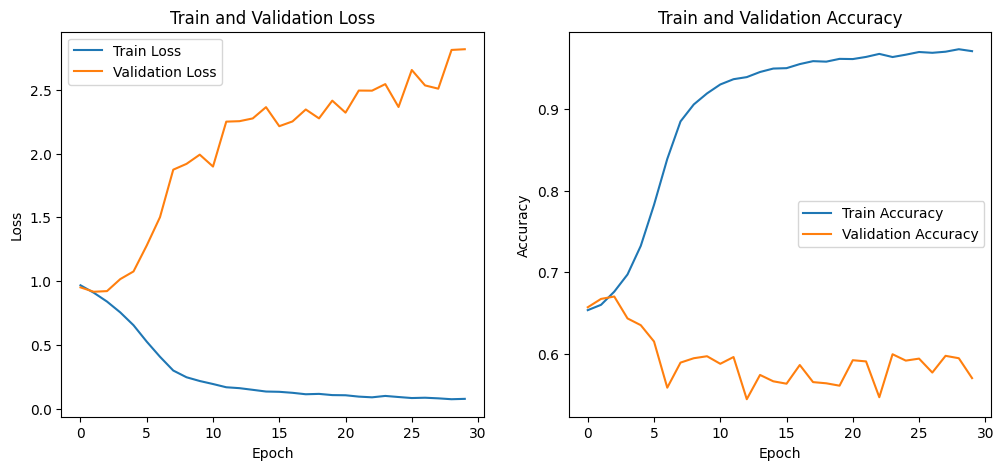

In [11]:
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm   

# Định nghĩa mô hình và các tham số huấn luyện
model = MultimodalModel()   
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
 
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
 
criterion = nn.CrossEntropyLoss()  # Sử dụng CrossEntropyLoss cho phân loại đa lớp
optimizer = optim.Adam(model.parameters(), lr=1e-4)   

num_epochs = 30

# Bắt đầu quá trình huấn luyện
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_true, train_pred = [], []
 
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        images, age, density, labels = batch
        images, age, density, labels = (
            images.to(device),
            age.to(device),
            density.to(device),
            labels.to(device)
        )

        # Forward pass
        outputs = model(images, age, density)

        # Tính loss
        loss = criterion(outputs, labels)   

        # Dự đoán nhãn
        _, predicted_labels = torch.max(outputs, 1)  # Lấy nhãn có xác suất cao nhất
        train_true.extend(labels.cpu().numpy())
        train_pred.extend(predicted_labels.cpu().numpy())

        # Backward pass và optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Cộng dồn loss cho epoch
        train_loss += loss.item()

    # Tính độ chính xác trên tập train
    train_acc = accuracy_score(train_true, train_pred)
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0
    val_true, val_pred = [], []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
            images, age, density, labels = batch
            images, age, density, labels = (
                images.to(device),
                age.to(device),
                density.to(device),
                labels.to(device)
            )

            # Forward pass
            outputs = model(images, age, density)

            # Tính loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Dự đoán nhãn
            _, predicted_labels = torch.max(outputs, 1)
            val_true.extend(labels.cpu().numpy())
            val_pred.extend(predicted_labels.cpu().numpy())

    # Tính độ chính xác trên tập validation
    val_acc = accuracy_score(val_true, val_pred)
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_acc:.4f}, "
          f"Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_acc:.4f}")

# Vẽ đồ thị độ chính xác và loss
plt.figure(figsize=(12, 5))

# Đồ thị Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# Đồ thị Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.show()


In [16]:
# Khởi tạo mô hình
model = MultimodalModel()   
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load trọng số mô hình đã lưu
model.load_state_dict(torch.load('/media/mountHDD2/chuyenmt/Dataset/VinDr-Mammo/Processed/multimodal_model_weights.pth'))

# Đặt mô hình vào chế độ evaluation
model.eval()

print("Model loaded successfully!")

# Bây giờ bạn có thể sử dụng mô hình để đánh giá hoặc dự đoán trên tập dữ liệu test


Model loaded successfully!


/tmp/ipykernel_16054/1316474908.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/media/mountHDD2/chuyenmt/Dataset/VinDr-Mammo/Processed

Testing: 100%|███████████████████████████████████████████████████████████████████████| 256/256 [00:01<00:00, 191.17it/s]


Test Loss: 2.5546, Test Accuracy: 0.6060
  Class  Sensitivity (%)  Specificity (%)  Precision (%)  Accuracy (%)
0    C1        81.506339        37.199434      71.112557     66.210938
1    C2        27.408994        81.214421      30.117647     68.945312
2    C3         1.041667        98.872951       4.347826     94.287109
3    C4         7.000000        98.511294      19.444444     94.042969
4    C5        27.272727        99.251497      44.444444     97.705078


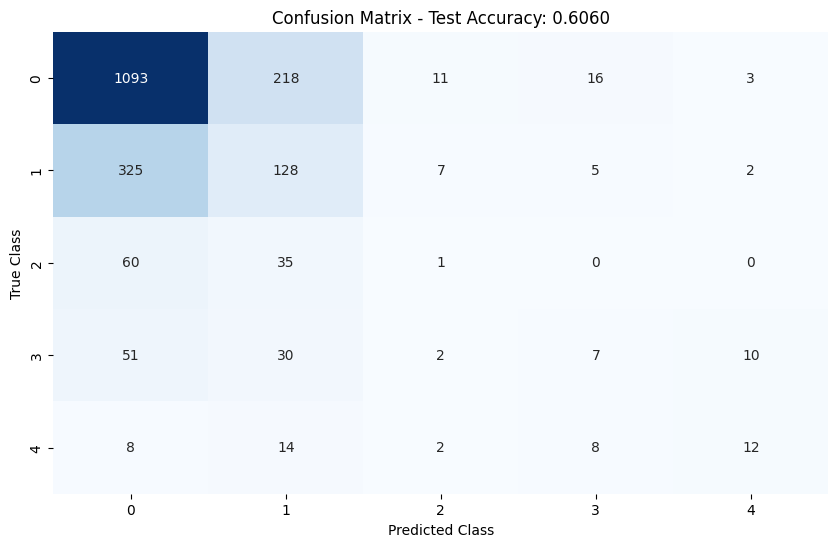

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm   
 

criterion = nn.CrossEntropyLoss()  # Sử dụng CrossEntropyLoss cho phân loại đa lớp
test_loss = 0
test_true, test_pred = [], []

with torch.no_grad():  # Tắt gradient để tăng tốc độ tính toán
    for batch in tqdm(test_loader, desc="Testing"):
        images, age, density, labels = batch
        images, age, density, labels = (
            images.to(device),
            age.to(device),
            density.to(device),
            labels.to(device)
        )

        # Forward pass
        outputs = model(images, age, density)

        # Tính loss
        loss = criterion(outputs, labels)
        test_loss += loss.item()  # Cộng dồn loss

        # Dự đoán nhãn
        _, predicted_labels = torch.max(outputs, 1)
        test_true.extend(labels.cpu().numpy())
        test_pred.extend(predicted_labels.cpu().numpy())

# Tính độ chính xác trên tập test
test_acc = accuracy_score(test_true, test_pred)
test_loss /= len(test_loader)  # Trung bình loss
 
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Tính toán confusion matrix
conf_matrix = confusion_matrix(test_true, test_pred)

# Initialize lists to store metrics for each class
sensitivity = []
specificity = []
precision = []
accuracy = []

# Calculate metrics for each class
for i in range(len(conf_matrix)):
    TP = conf_matrix[i, i]
    FN = np.sum(conf_matrix[i, :]) - TP
    FP = np.sum(conf_matrix[:, i]) - TP
    TN = np.sum(conf_matrix) - (TP + FN + FP)

    sen = TP / (TP + FN) if (TP + FN) != 0 else 0
    spe = TN / (TN + FP) if (TN + FP) != 0 else 0
    ppr = TP / (TP + FP) if (TP + FP) != 0 else 0
    acc = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0

    sensitivity.append(sen * 100)
    specificity.append(spe * 100)
    precision.append(ppr * 100)
    accuracy.append(acc * 100)

# Display the results in a table
results_df = pd.DataFrame({
    'Class': [f'C{i+1}' for i in range(len(conf_matrix))],
    'Sensitivity (%)': sensitivity,
    'Specificity (%)': specificity,
    'Precision (%)': precision,
    'Accuracy (%)': accuracy
})

print(results_df)

# Plot the confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title(f'Confusion Matrix - Test Accuracy: {test_acc:.4f}')
plt.show()
 
  


In [18]:
import os

# Tạo thư mục 'output' nếu chưa tồn tại
output_folder = '/media/mountHDD2/chuyenmt/BrEaST/Mammo/Output'
 

# Lưu confusion matrix dưới dạng hình ảnh
conf_matrix_path = os.path.join(output_folder, 'confusion_matrix.png')
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title(f'Confusion Matrix - Test Accuracy: {test_acc:.4f}')
plt.savefig(conf_matrix_path)  # Lưu hình ảnh
plt.close()  # Đóng figure để giải phóng bộ nhớ

print(f"Confusion matrix saved to: {conf_matrix_path}")

# Lưu bảng results_df dưới dạng CSV
results_path = os.path.join(output_folder, 'results.csv')
results_df.to_csv(results_path, index=False)

print(f"Results saved to: {results_path}")

Confusion matrix saved to: /media/mountHDD2/chuyenmt/BrEaST/Mammo/Output/confusion_matrix.png
Results saved to: /media/mountHDD2/chuyenmt/BrEaST/Mammo/Output/results.csv


In [ ]:
output_folder = f'output_{args.model}'
os.makedirs(output_folder, exist_ok=True)